In [1]:
import json
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)
import sys
sys.path.insert(0,'../')
from numpy import genfromtxt
import numpy as np
from pak.evaluation import MOTA
from cabbage.data.video import VideoData
from experiments import MOT16_Experiments
from time import time

root = Settings['data_root']

mot16 = MOT16_Experiments(root)

print("check:")
print(mot16.mot16_11_detections.shape)
print("")



__start = time()
result = genfromtxt('../build/RESULT.txt', delimiter=' ', dtype='uint32')
__end = time()
print('elapsed', __end - __start)
print('load results:', result.shape)



def extract_ids(result):
    #TODO: make this stuff better..
    
    candidates = []
    n = np.max(result[:,1])  # total number of nodes
    
    Nodes = [i for i in range(n+1)]
    
    
    for i, j, edge in result:
        assert(i < j)
        has_edge = edge == 0
        
        if has_edge:
            repres = Nodes[i]
            Nodes[j] = repres

    #print(Nodes)     
    return Nodes

__start = time()
Nodes = extract_ids(result)
__end = time()
print('elapsed', __end - __start)
print('finished extracting ids')

# translate to sensible id's
n_unique = len(np.unique(Nodes))
lookup = {}
for new,old in zip(list(range(n_unique)), np.unique(Nodes)):
    lookup[old] = new

print("Unique ids:", n_unique)
print("total nodes:", len(Nodes))

{'data_root': '/home/data',
 'deepmatch': '/home/deepmatching_1.2.2_c++/deepmatching-static',
 'graph_solver': '/home/cabbage/build/sample'}
check:
(8125, 6)

elapsed 0.406604528427124
load results: (111156, 3)
elapsed 0.29419660568237305
finished extracting ids
Unique ids: 36
total nodes: 472


In [4]:
from pak.post_processing import MOT
ALL_DETECTIONS = mot16.mot16_11_detections[0:len(Nodes)]  # as we do not need all frames..
#ALL_DETECTIONS = mot16.mot16_11_true_detections_no_pid[0:len(Nodes)]  # as we do not need all frames..

# Hy = mot16.get_MOT16_11_trajectories()  # true detections
# print(Hy.shape)

Dt = []
for i, (pid, data) in enumerate(zip(Nodes, ALL_DETECTIONS)):
    frame, x, y, w, h, score = data
    Dt.append((frame, pid, x, y, w, h, score))
Dt = np.array(Dt)


print("before", Dt.shape)
Dt = MOT.remove_short_tracks(
    MOT.remove_duplicates(Dt, lambda x: x[6]),
    min_length=4)


# print("after", Dt.shape)
Dt = Dt[:,0:6]

# print(Dt[0:6].astype('object'))
# Dt_f1 = utils.extract_eq(Dt, col=0, value=1)
# Dt_f2 = utils.extract_eq(Dt, col=0, value=2)
# print("qq", Dt_f2.shape)


Gt = mot16.get_MOT16_11_gt_trajectories()
vd = VideoData(Gt)
Gt = vd.get_n_first_frames(50)

print("GT", Gt.shape)

threshold=0.5
result, info = MOTA.evaluate_aabb(Gt, Dt, threshold, info=True)


print("MOTA:", result)
print("\tinfo:", info)


before (472, 7)
GT (251, 6)
MOTA: 0.462151394422
	info: {'FN': 36, 'FP': 97, 'IDSW': 2, 'GT': 251}


/home/data/MOT16 found :)
MOT16: load memmapped file /home/data/MOT16/train/MOT16-11/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded


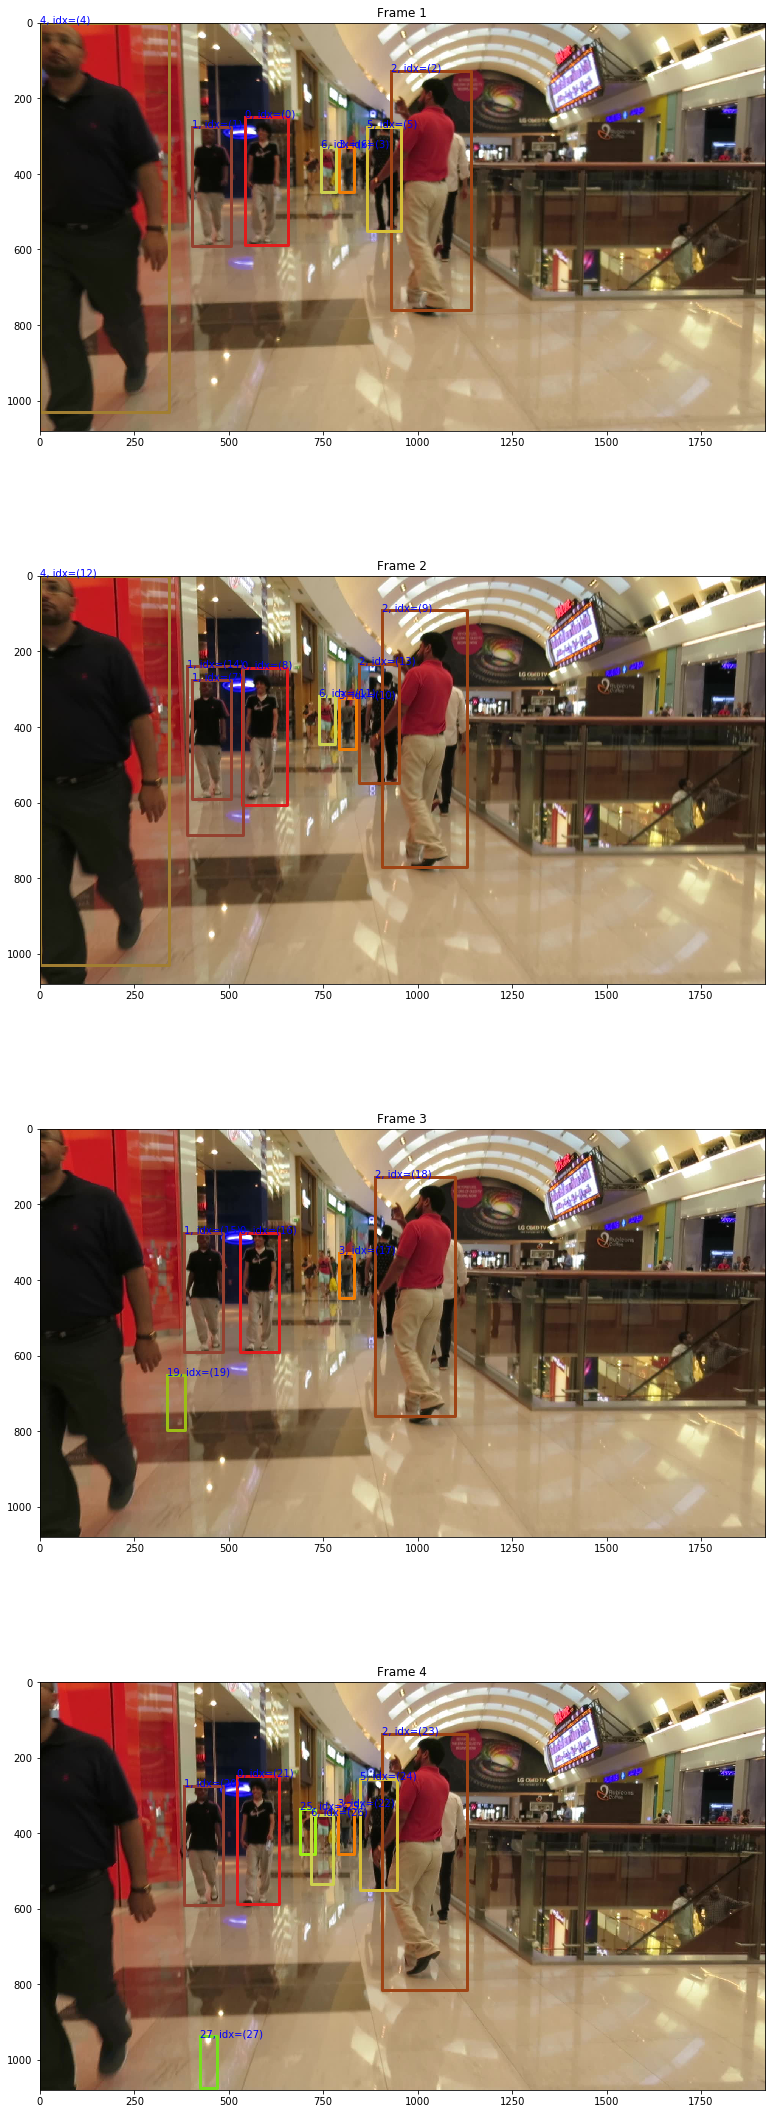

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from pak import utils
from cselect import color as cs
from pak.datasets.MOT import MOT16
mot16__ = MOT16(root)

X, Y_det, Y_gt = mot16__.get_train("MOT16-11", memmapped=True)

n_unique = len(np.unique(Nodes))
colors = cs.lincolor(n_unique, random_sat=True, random_val=True)
COLOR_LOOKUP = {}
for pid, color in zip(np.unique(Nodes), colors):
    COLOR_LOOKUP[str(pid)] = color

frames = range(1, 5)
# plt.imshow(X[0])

# Y_f1 = utils.extract_eq(mot16.mot16_11_detections, 
#                                col=0, value=2)

# print(Y_f1.shape)
# for idx, (_, x, y, w, h, _) in enumerate(Y_f1):
#     bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
#     plt.text(x, y, str(idx), color='white')
#     plt.plot(bbX, bbY, linewidth=3)

fig = plt.figure(figsize=(13,13*3))
_h = len(frames); _w = 1
for idx, f in enumerate(frames):
    ax = fig.add_subplot(_h,_w,idx+1)
    ax.imshow(X[f])
    #Y_f1 = utils.extract_eq(Dt, col=0, value=f)
    for idx, (f_, pid, x, y, w, h) in enumerate(Dt):
        if f == f_:
            color = COLOR_LOOKUP[str(int(pid))]
            bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
            ax.text(x, y, str(int(pid)) + ", idx=(" + str(idx) + ")", color='blue')
            ax.plot(bbX, bbY, linewidth=3, color=color/255)
            ax.set_title('Frame ' + str(f))
        

plt.show()